# Measure of Contribution to Model Performance and Deletion Robustness

## Staying Probability

Intuitively, data sources with higher staying probability contribute more to deletion robustness. In this experiment, we create data sources with equal number of randomly sampled training examples and assign each of them different independent staying probability. We then compute their semivalue and corresponding DeRDaVa scores and repeat the procedure for 50 times. A sample run is included below:

### $\mathtt{Diabetes}$ dataset, SVM model, $10 + 1$ data sources, $\mathtt{Beta(16, 4)}$ prior

In [ ]:
import numpy as np
from derdava.coalition_probability import IndependentCoalitionProbability
from derdava.data_source import generate_random_data_sources
from derdava.data_valuation import ValuableModel
from derdava.dataset import load_dataset
from derdava.model_utility import IClassificationModel, model_linear_svm
from sklearn.model_selection import train_test_split

X, y = load_dataset('diabetes')
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)

NUM_OF_DATA_SOURCES = 11
support_set = tuple(range(NUM_OF_DATA_SOURCES))

staying_probabilities = {i: i / 10 for i in range(NUM_OF_DATA_SOURCES)}
coalition_probability = IndependentCoalitionProbability(staying_probabilities)

model = model_linear_svm

N_ITER = 50
all_semivalues = np.zeros((N_ITER, NUM_OF_DATA_SOURCES))
all_derdava_values = np.zeros((N_ITER, NUM_OF_DATA_SOURCES))

for N in range(N_ITER):
    indices = np.random.choice(len(X), size=NUM_OF_DATA_SOURCES * 10, replace=False)
    X_train = X[indices]
    y_train = y[indices]
    data_sources = generate_random_data_sources(X_train, y_train, num_of_data_sources=NUM_OF_DATA_SOURCES)
    model_utility_function = IClassificationModel(model, data_sources, X_test, y_test)
    valuable_model = ValuableModel(support_set, model_utility_function)
    beta_values = valuable_model.valuate(data_valuation_function="beta", 
                                         coalition_probability=coalition_probability, alpha=16, beta=4)
    derdava_values = valuable_model.valuate(data_valuation_function="robust beta", 
                                            coalition_probability=coalition_probability, alpha=16, beta=4)
    for i in range(NUM_OF_DATA_SOURCES):
        all_semivalues[N, i] = beta_values[i]
        all_derdava_values[N, i] = derdava_values[i]

In [ ]:
from statistics import mean, stdev

all_staying_probabilities = list(staying_probabilities.values())
mean_semivalues = np.zeros(NUM_OF_DATA_SOURCES)
stdev_semivalues = np.zeros(NUM_OF_DATA_SOURCES)
mean_derdava_values = np.zeros(NUM_OF_DATA_SOURCES)
stdev_derdava_values = np.zeros(NUM_OF_DATA_SOURCES)
for i in range(NUM_OF_DATA_SOURCES):
    mean_semivalues[i] = mean(all_semivalues[:, i])
    stdev_semivalues[i] = stdev(all_semivalues[:, i])
    mean_derdava_values[i] = mean(all_derdava_values[:, i])
    stdev_derdava_values[i] = stdev(all_derdava_values[:, i])

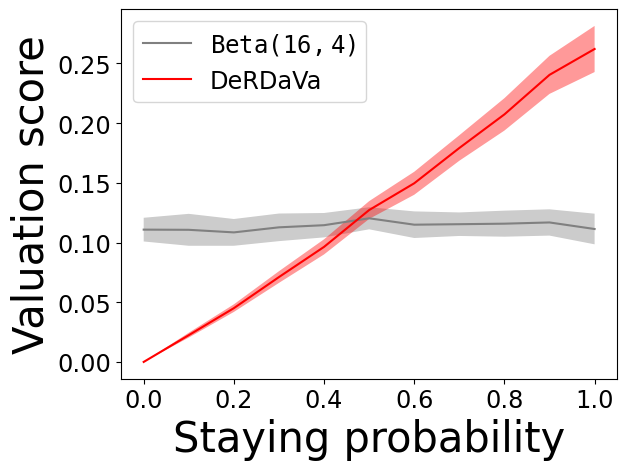

In [19]:
import matplotlib.pyplot as plt
import os

fig, ax = plt.subplots()

semivalue_line, = ax.plot(all_staying_probabilities, mean_semivalues, color='gray')
semivalue_line.set_label("$\mathtt{Beta(16, 4)}$")
ax.fill_between(all_staying_probabilities, mean_semivalues-1/2 * stdev_semivalues, mean_semivalues+1/2 * stdev_semivalues, facecolor="gray", alpha=0.4)

derdava_value_line, = ax.plot(all_staying_probabilities, mean_derdava_values, color='red')
derdava_value_line.set_label("DeRDaVa")
ax.fill_between(all_staying_probabilities, mean_derdava_values-1/2 * stdev_derdava_values, mean_derdava_values+1/2 * stdev_derdava_values, facecolor="red", alpha=0.4)
                      
ax.set_xlabel("Staying probability", fontsize=30)
ax.set_ylabel("Valuation score", fontsize=30)
ax.legend(fontsize='xx-large')
ax.tick_params(axis='both', labelsize='xx-large')

plt.show()
PATH_TO_IMAGES = "./images/staying_probability/"
if not os.path.isdir(PATH_TO_IMAGES):
    os.makedirs(PATH_TO_IMAGES)
fig.savefig(os.path.join(PATH_TO_IMAGES, "sp_10_diabetes_svm_beta_16_4"), dpi=300, bbox_inches='tight')